# Socioeconomic data and TOC entitlements
* Entitlements assigned to census tracts
* Which census tracts (what income levels or median household income) have seen TOC entitlements?
* See if tract is composed of mostly TOC-eligible parcels
* Then look at Census characteristics of mostly TOC-eligible tracts vs not

In [1]:
import boto3
import geopandas as gpd
import intake
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pcts_census_utils
import utils

In [2]:
catalog = intake.open_catalog("../catalogs/*.yml")

s3 = boto3.client('s3')
bucket_name = 'city-planning-entitlements'

## A1. Identify this dichotomy of tracts that are mostly TOC-eligible vs not

In [3]:
def toc_tracts_clean_and_aggregate():
    # Import data
    crosswalk_parcels_tracts = pd.read_parquet(f's3://{bucket_name}/data/crosswalk_parcels_tracts.parquet')

    s3.download_file(bucket_name, f'gis/intermediate/TOC_Parcels.parquet', '../gis/TOC_Parcels.parquet')
    toc_parcels = gpd.read_parquet('../gis/TOC_Parcels.parquet')
    os.remove('../gis/TOC_Parcels.parquet')

    df = pd.merge(crosswalk_parcels_tracts, 
         toc_parcels[toc_parcels.TOC_Tier > 0].drop(columns = 'TOC_Tier'), 
         on = 'AIN', how = 'left', validate = '1:1')
    
    # Get rid of duplicate AIN's
    df = df[df.num_AIN == 1]
    
    # Tag if the parcel counts as in TOC tier or not
    def in_tier(row):
        if row.TOC_Tier != 0:
            return 1
        elif row.TOC_Tier == 0:
            return 0

    df = df.assign(
        in_tier = df.apply(in_tier, axis=1)
    )
    
    # Aggregate by in_tier 
    df = (df.groupby(["GEOID", "pop", "parcel_tot", "in_tier"])
          .agg({"num_AIN": "sum",
               "parcelsqft":"sum"})
          .reset_index()
         )
    
    # If GEOID has 2 observations, one in_tier==1 and other in_tier==0, let's keep the in_tier==1
    df["obs"] = df.groupby("GEOID").cumcount() + 1
    df["max_obs"] = df.groupby("GEOID")["obs"].transform("max")
    
    df = (df[(df.max_obs == 1) | 
             ((df.in_tier == 1) & (df.max_obs == 2))]
          .drop(columns = ["obs", "max_obs"])
         )
    
    
    # Also, count the total of AIN within each tract
    total_AIN = (crosswalk_parcels_tracts[crosswalk_parcels_tracts.num_AIN == 1]
                    .groupby(['GEOID'])
                    .agg({'num_AIN':'sum'})
                    .rename(columns = {'num_AIN':'total_AIN'})
                    .reset_index()
                   )
    
    # Merge together 
    df2 = pd.merge(df, total_AIN, on = 'GEOID', how = 'left', validate = 'm:1')
    
    # Calculate the % of AIN that falls within TOC tiers and % of area within TOC tiers
    df2 = (df2.assign(
            pct_AIN = df2.num_AIN / df2.total_AIN,
            pct_area = df2.parcelsqft / df2.parcel_tot,
        ).sort_values("GEOID")
           .reset_index(drop=True)
    )
    
    return df2

In [4]:
df = toc_tracts_clean_and_aggregate()

## A2. Merge in number of TOC entitlements that tract had

In [5]:
# Download parcels with TOC entitlement info, and only keep parcels with TOC ent
def tracts_with_TOC_ent():    
    parcels = gpd.read_file(
        f"s3://{bucket_name}/gis/intermediate/toc_eligible_parcels_with_entitlements.geojson"
    ).to_crs('EPSG:4326')

    toc_parcels = parcels[parcels.num_TOC > 0][['AIN', 'num_TOC', 'num_nonTOC']]

    crosswalk_parcels_tracts = pd.read_parquet(f's3://{bucket_name}/data/crosswalk_parcels_tracts.parquet')

    crosswalk_parcels_tracts = crosswalk_parcels_tracts[["AIN", "GEOID"]]
    
    df = pd.merge(crosswalk_parcels_tracts[["AIN", "GEOID"]], 
         toc_parcels, on = "AIN", how = "left", validate = "1:1")
    
    # Fill in NaNs with zeroes
    df = df.assign(
        num_TOC = df.num_TOC.fillna(0).astype(int),
        num_nonTOC = df.num_nonTOC.fillna(0).astype(int),
    )
    
    # Aggregate to tract-level
    df = (df.groupby("GEOID")
          .agg({"num_TOC": "sum", "num_nonTOC": "sum"})
          .reset_index()
         )
    
    return df

In [6]:
toc_ent = tracts_with_TOC_ent()

In [7]:
# Merge together
df = pd.merge(df, toc_ent, on = "GEOID", how = "left", validate = "1:1")
df.head()

,GEOID,pop,parcel_tot,in_tier,num_AIN,parcelsqft,total_AIN,pct_AIN,pct_area,num_TOC,num_nonTOC
0,06037101110,4566,8.705370e+06,0,1159,8.618394e+06,1159,1.0,0.990009,0,0
1,06037101122,3064,1.596906e+07,0,1316,1.596906e+07,1316,1.0,1.000000,0,0
2,06037101210,6043,5.081114e+06,0,504,4.625910e+06,504,1.0,0.910413,0,0
3,06037101220,3340,5.245595e+06,0,688,5.189783e+06,688,1.0,0.989360,0,0
4,06037101300,4285,1.411616e+07,0,1403,1.370158e+07,1403,1.0,0.970631,0,0


## B1. Grab Census data

In [8]:
# Commute mode
commute_modes = ["workers_transit", "workers_walk", "workers_bike"]

commute = pcts_census_utils.transform_census_percent("commute", 2018, "workers", 
                                   commute_modes, "non_car", 
                                   "non_car", "workers_total")

commute.head(2)

,GEOID,non_car,workers_total,pct_non_car
0,06037101110,46,1927,0.023871
1,06037101122,11,1907,0.005768


In [9]:
# Renter occupied
tenure_group = ["pop_renter"]

tenure = pcts_census_utils.transform_census_percent("tenure", 2018, "pop", 
                                  tenure_group, "pop_renter", 
                                  "pop_renter", "pop_total")

tenure.head(2)

,GEOID,pop_renter,pop_total,pct_pop_renter
0,06037101110,2199,4219,0.521214
1,06037101122,577,3234,0.178417


In [10]:
# Zero vehicle 
vehicle_group = ["workers_veh0"]

vehicle = pcts_census_utils.transform_census_percent("vehicles", 2018, "workers", 
                                   vehicle_group, "zero_veh_workers",
                                   "zero_veh_workers", "workers_total")

vehicle.head(2)

,GEOID,workers_total,zero_veh_workers,pct_zero_veh_workers
0,06037101110,1927,0,0.000000
1,06037101122,1907,8,0.004195


In [11]:
"""
# Race 
race_group = ["pop_black", "pop_asian", "pop_amerind", "pop_pacis", "pop_race2", "pop_other"]

race = pcts_census_utils.transform_census_percent("race", 2018, "pop", 
                                   race_group, "non_white",
                                   "non_white", "pop_total")

race.head(2)
"""

'\n# Race \nrace_group = ["pop_black", "pop_asian", "pop_amerind", "pop_pacis", "pop_race2", "pop_other"]\n\nrace = pcts_census_utils.transform_census_percent("race", 2018, "pop", \n                                   race_group, "non_white",\n                                   "non_white", "pop_total")\n\nrace.head(2)\n'

In [12]:
# Race
def transform_census_race():
    # Grab the tables individually.
    # White non-Hispanic is a separate table (with a diff main_var)
    race_total =  pcts_census_utils.grab_census_table("raceethnicity", 2018, "total")
    race_white = pcts_census_utils.grab_census_table("raceethnicity", 2018, "whitenonhisp")

    # Append together
    race = pd.concat([race_total, race_white])
    
    cols = ["whitenonhisp_total", "total_total"]
    race2 = pcts_census_utils.make_wide(race, cols)
    
    race2 = (race2.assign(
            pct_whitenonhisp = race2.whitenonhisp_total / race2.total_total,
        ).rename(columns = {
            "total_total": "pop_total", 
            "whitenonhisp_total": "pop_whitenonhisp"
        })
    )
    
    return race2

race = transform_census_race()
race.head(2)

,GEOID,pop_total,pop_whitenonhisp,pct_whitenonhisp
0,06037101110,4314,2516,0.583217
1,06037101122,3239,2755,0.850571


## B2. Merge in Census data

In [13]:
# Grab the geometry for tracts
census_tracts = catalog.census_tracts.read()
census_tracts = (census_tracts[["GEOID10", "geometry"]]
                 .rename(columns = {"GEOID10": "GEOID"})
                 .to_crs("EPSG:4326")
                )

In [14]:
# Merge the census pieces together
c1 = pd.merge(commute, vehicle, on = ["GEOID", "workers_total"], how = "left", validate = "1:1")
c2 = pd.merge(tenure, race, on = ["GEOID", "pop_total"], how = "left", validate = "1:1")
c3 = pd.merge(c1, c2, on = "GEOID", how = "left", validate = "1:1")

# Skip income for now, need to use incomerange table
"""
Denominators
zero_veh_workers / workers_total
non_car / workers_total
pop_renter / pop_total
non_white / pop_total
"""

drop_me = ["pct_non_car", "pct_zero_veh_workers", "pct_pop_renter", "pct_whitenonhisp"]
c3 = c3.drop(columns = drop_me)

# Merge our TOC info with census info
c4 = pd.merge(df, c3, on = "GEOID", how = "left", validate = "1:1")

# Merge in geometry
c5 = pd.merge(census_tracts, c4, on = "GEOID", how = "left", validate = "1:1")

## C1. Summary stats
Instead of unweighted averages, we should definitely weight by population. 
Aggregate counts for # non car, # zero veh workers, etc into the 2 groups.
Then calculate % non car, % zero veh workers, etc.

In [15]:
# We will count tract as being a TOC tract if over 50% of its area or 
# over 50% of its parcels are within a TOC Tier.
def set_groups(df):
    cutoff_AIN = 0.5
    cutoff_area = 0.5
    
    def set_cutoffs(row):
        toc_AIN = 0
        toc_area = 0
        toc_ENT = 0
        
        if (row.in_tier == 1) & (row.pct_AIN >= cutoff_AIN):
            toc_AIN = 1
        if (row.in_tier == 1) & (row.pct_area >= cutoff_area):
            toc_area = 1
        if (row.num_TOC > 0):
            toc_ENT = 1
        
        return pd.Series([toc_AIN, toc_area, toc_ENT], 
                         index=['toc_AIN', 'toc_area', 'toc_ENT'])
    
    with_cutoffs = df.apply(set_cutoffs, axis=1)
    
    df = pd.concat([df, with_cutoffs], axis=1)
    
    return df

In [16]:
final = set_groups(c5)
final.head(2)

,GEOID,geometry,pop,parcel_tot,in_tier,num_AIN,parcelsqft,total_AIN,pct_AIN,pct_area,...,num_nonTOC,non_car,workers_total,zero_veh_workers,pop_renter,pop_total,pop_whitenonhisp,toc_AIN,toc_area,toc_ENT
0,06037297602,"MULTIPOLYGON (((-118.28798 33.72258, -118.2879...",4048,3.953546e+06,1.0,101.0,5.522768e+05,821.0,0.123021,0.139692,...,0.0,101,1840,77,2065,3730,<NA>,0,0,0
1,06037297601,"MULTIPOLYGON (((-118.27738 33.70783, -118.2773...",2706,1.770137e+06,0.0,256.0,1.706503e+06,256.0,1.000000,0.964051,...,0.0,42,1147,26,2244,2706,<NA>,0,0,0


In [17]:
# Income (use ranges to calculate median)
# These have to be calculated after tracts are ID as TOC or not
income_ranges = pcts_census_utils.income_ranges

# The new_var columns to keep all have prefix "total_". 
# Can switch out if we're interested in other races' income ranges
keep = []
for x in income_ranges:
    keep.append("total_" + x)

def process_income_before_iqr():
    df = pcts_census_utils.grab_census_table("incomerange", 2018, "total")
    df = df.pivot(index="GEOID", columns = "new_var", values = "num")
    df.columns.name = ""
    df = df.reset_index()
    
    return df

income = process_income_before_iqr()
income.head(2)

,GEOID,total_gt200,total_lt10,total_r100to124,total_r10to14,total_r125to149,total_r150to199,total_r15to19,total_r20to24,total_r25to29,total_r30to34,total_r35to39,total_r40to44,total_r45to49,total_r50to59,total_r60to74,total_r75to99,total_total
0,06037101110,44.0,110.0,91.0,97.0,93.0,109.0,70.0,76.0,123.0,96.0,54.0,78.0,88.0,64.0,126.0,277.0,1596.0
1,06037101122,192.0,52.0,114.0,18.0,105.0,133.0,0.0,15.0,39.0,38.0,7.0,40.0,23.0,62.0,186.0,232.0,1256.0


In [18]:
print(f"# tracts where groups differ based on cut-offs: {len(final[final.toc_area != final.toc_AIN])}")
print(final.toc_area.value_counts())
print(final.toc_AIN.value_counts())

# tracts where groups differ based on cut-offs: 30
0    604
1    545
Name: toc_area, dtype: int64
0    600
1    549
Name: toc_AIN, dtype: int64


In [19]:
# Calculate IQR for income
def aggregate_by_toc(df, category_col, income_df):
    df = df[["GEOID", category_col]]

    df2 = pd.merge(df, income_df, on = "GEOID", how = "left", validate = "1:1")

    # Aggregate by toc_area or toc_AIN
    df2 = df2.pivot_table(index = category_col, aggfunc = "sum").reset_index()
    
    # Calculate IQR
    iqr = (df2.apply(
            lambda r: pd.Series(pcts_census_utils.income_percentiles(r, [25,50,75]), dtype="float64"),
            axis=1,
        ).rename(columns={0: "Q1", 1: "Q2", 2: "Q3"})
    )
    
    # Change unit income IQR from thousands of dollars to dollars
    DOLLAR_UNIT = 1_000
    
    iqr = (iqr.assign(
            Q1 = iqr.Q1 * DOLLAR_UNIT,
            Q2 = iqr.Q2 * DOLLAR_UNIT, 
            Q3 = iqr.Q3 * DOLLAR_UNIT,
        ).rename(columns = {"Q1": "income_Q1", "Q2": "income_Q2", "Q3": "income_Q3"})
    )

    # Merge IQR in
    df3 = pd.merge(df2[[category_col]], iqr, left_index = True, right_index = True, 
                   how = "left", validate = "1:1")
    
    return df3

def summary_stats(df, category_col, income_df):
    # Number of tracts by cut-offs
    num_tracts = (df.groupby(category_col).agg({
            "GEOID": "count"
        }).reset_index()
            .rename(columns = {"GEOID": "num_tracts"})
    )
    
    # Calculate totals
    totals = df.groupby(category_col).agg({
            "zero_veh_workers": "sum",
            "non_car": "sum",
            "workers_total": "sum",
            "pop_renter": "sum",
            "pop_whitenonhisp": "sum",
            "pop_total": "sum",
    }).reset_index()
    
    # Calculate percents
    percents = totals.assign(
        pct_zero_veh = totals.zero_veh_workers / totals.workers_total,
        pct_non_car = totals.non_car / totals.workers_total,
        pct_renter = totals.pop_renter / totals.pop_total,
        pct_white = totals.pop_whitenonhisp / totals.pop_total,
    )
    
    # Calculate income IQR
    income_iqr = aggregate_by_toc(df, category_col, income_df)
    
    # Create final table
    summary = pd.merge(percents, num_tracts, on = category_col, validate = "1:1")
    summary = pd.merge(summary, income_iqr, on = category_col, validate = "1:1")
    
    return summary

In [20]:
#final_to_save = pd.DataFrame(final.drop(columns = "geometry"))
#final_to_save.to_parquet("s3://city-planning-entitlements/data/final/census_tract_stats.parquet")

In [21]:
by_AIN = summary_stats(final, "toc_AIN", income)
by_AIN

,toc_AIN,zero_veh_workers,non_car,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,25474,68832,908927,835758,274903,1840124,0.028026,0.075729,0.454186,0.149394,600,35513.929030,74390.156778,137414.803186
1,1,95431,198640,1046500,1501681,168351,2082857,0.091191,0.189814,0.720972,0.080827,549,22581.190387,48225.917068,93110.836769


In [22]:
by_area = summary_stats(final, "toc_area", income)
by_area

,toc_area,zero_veh_workers,non_car,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,25446,70538,917375,836060,286740,1853999,0.027738,0.076891,0.450950,0.154660,604,35751.293048,74838.461538,138283.334452
1,1,95459,196934,1038052,1501379,156514,2068982,0.091960,0.189715,0.725661,0.075648,545,22358.011215,47672.337644,92041.996104


In [23]:
by_toc_ENT = summary_stats(final, "toc_ENT", income)
by_toc_ENT

,toc_ENT,zero_veh_workers,non_car,workers_total,pop_renter,pop_whitenonhisp,pop_total,pct_zero_veh,pct_non_car,pct_renter,pct_white,num_tracts,income_Q1,income_Q2,income_Q3
0,0,82797,194297,1610836,1838206,376433,3289095,0.051400,0.120619,0.558879,0.114449,978,29159.684490,63494.382301,120280.513445
1,1,38108,73175,344591,499233,66821,633886,0.110589,0.212353,0.787575,0.105415,171,23698.807672,49645.214521,94661.588643


In [24]:
writer = pd.ExcelWriter("../outputs/07-toc-census-stats.xlsx", engine="xlsxwriter")

by_AIN.to_excel(writer, sheet_name = "by_pct_AIN")
by_area.to_excel(writer, sheet_name = "by_pct_area")
by_toc_ENT.to_excel(writer, sheet_name = "by_TOC_ENT")

writer.save()

## C2. Make map of tracts

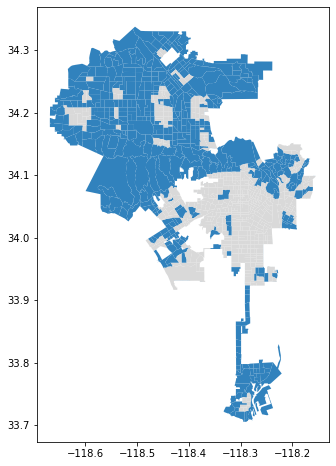

In [25]:
# By AIN
fig, ax = plt.subplots(figsize=(8,8))

final.plot(column="toc_AIN", ax=ax, cmap = "tab20c", legend=False)

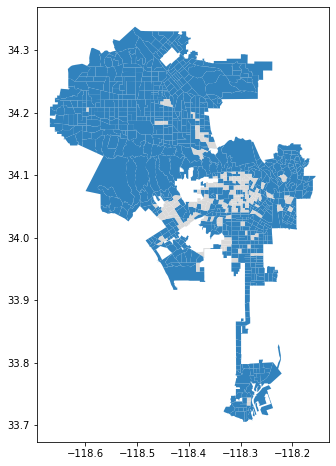

In [26]:
# By TOC ENT
fig, ax = plt.subplots(figsize=(8,8))

final.plot(column="toc_ENT", ax=ax, cmap = "tab20c", legend=False)